In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

Dataset:

MIND (**MIND-small**), by randomly sampling 50,000 users and their behavior logs.
Only training and validation sets are contained in the MIND-small dataset.

### Load news.tsv 

detailed information of news articles involved in the behaviors.tsv file

#### Columns
* News ID 
* Category 
* SubCategory
* Title
* Abstract
* URL
* Title Entities (entities contained in the title of this news)
* Abstract Entities (entites contained in the abstract of this news)


<strong>Title Entities</strong> | [{"Label": "PGA Tour", "Type": "O", "WikidataId": "Q910409", "Confidence": 1.0, "OccurrenceOffsets": [0], "SurfaceForms": ["PGA Tour"]}]	

<strong>Abstract Entites</strong> | [{"Label": "PGA Tour", "Type": "O", "WikidataId": "Q910409", "Confidence": 1.0, "OccurrenceOffsets": [35], "SurfaceForms": ["PGA Tour"]}]

The descriptions of the dictionary keys in the "Entities" column are listed as follows:
Keys | Description
------------- | -------------
Label | The entity name in the Wikidata knwoledge graph
Type | The type of this entity in Wikidata
WikidataId | The entity ID in Wikidata
Confidence | The confidence of entity linking
OccurrenceOffsets | The character-level entity offset in the text of title or abstract
SurfaceForms | The raw entity names in the original text

In [2]:
news_raw_data = pd.read_csv('Dataset/MINDsmall_train/news.tsv',sep='\t', header=None)
print("Shape of news data: ",news_raw_data.shape)
news_raw_data.head(3)

Shape of news data:  (51282, 8)


,0,1,2,3,4,5,6,7
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."


In [3]:
news_raw_data = news_raw_data.rename(columns={0:'News ID', 1:'Category', 2:'SubCategory', 3:'Title', 4:'Abstract', 5:'URL', 6:'Title Entities', 7:'Abstract Entities'})
news_raw_data.head(2)

,News ID,Category,SubCategory,Title,Abstract,URL,Title Entities,Abstract Entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."


### Load behaviors.tsv 

The behaviors.tsv file contains the impression logs and users' news click hostories. 

#### Columns
* Impression ID. The ID of an impression.
* User ID. The anonymous ID of a user.
* Time. The impression time with format "MM/DD/YYYY HH:MM:SS AM/PM".
* History. The news click history (ID list of clicked news) of this user before this impression. The clicked news articles are ordered by time.
* Impressions. List of news displayed in this impression and user's click behaviors on them (1 for click and 0 for non-click). The orders of news in a impressions
have been shuffled.


ref: https://www.kaggle.com/datasets/arashnic/mind-news-dataset

- data randomly sampled 1 million users who had at least 5 news clicks during 6 weeks from October 12 to November 22, 2019.

- impression logs have been used in the last week for test

- the logs in the fifth week for training

- used the click behaviors in the first four weeks to construct the news click history for user modeling

- Among the training data, the samples in the last day of the fifth week used as validation set

In [4]:
behaviours_raw_data = pd.read_csv('Dataset/MINDsmall_train/behaviors.tsv',sep='\t', header=None)
print(behaviours_raw_data.shape)
behaviours_raw_data.head(2)

(156965, 5)


,0,1,2,3,4
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...


In [5]:
behaviours_raw_data = behaviours_raw_data.rename(columns={0:'Impression ID', 1:'User ID', 2:'Time', 3:'History', 4:'Impressions'})
behaviours_raw_data.head(2)

,Impression ID,User ID,Time,History,Impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...


#### News data

In [6]:
news_val_data = pd.read_csv('Dataset/MINDsmall_dev/news.tsv',sep='\t', header=None)
print("Shape of news data: ",news_val_data.shape)
news_val_data.head(2)

Shape of news data:  (42416, 8)


,0,1,2,3,4,5,6,7
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N18955,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]


In [7]:
news_val_data = news_val_data.rename(columns={0:'News ID', 1:'Category', 2:'SubCategory', 3:'Title', 4:'Abstract', 5:'URL', 6:'Title Entities', 7:'Abstract Entities'})
news_val_data.head(2)

,News ID,Category,SubCategory,Title,Abstract,URL,Title Entities,Abstract Entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N18955,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]


#### Behaviors data

In [8]:
behaviours_val_data = pd.read_csv('Dataset/MINDsmall_dev/behaviors.tsv',sep='\t', header=None)
print(behaviours_val_data.shape)
behaviours_val_data.head(2)

(73152, 5)


,0,1,2,3,4
0,1,U80234,11/15/2019 12:37:50 PM,N55189 N46039 N51741 N53234 N11276 N264 N40716...,N28682-0 N48740-0 N31958-1 N34130-0 N6916-0 N5...
1,2,U60458,11/15/2019 7:11:50 AM,N58715 N32109 N51180 N33438 N54827 N28488 N611...,N20036-0 N23513-1 N32536-0 N46976-0 N35216-0 N...


In [9]:
behaviours_val_data = behaviours_val_data.rename(columns={0:'Impression ID', 1:'User ID', 2:'Time', 3:'History', 4:'Impressions'})
behaviours_val_data.head(2)

,Impression ID,User ID,Time,History,Impressions
0,1,U80234,11/15/2019 12:37:50 PM,N55189 N46039 N51741 N53234 N11276 N264 N40716...,N28682-0 N48740-0 N31958-1 N34130-0 N6916-0 N5...
1,2,U60458,11/15/2019 7:11:50 AM,N58715 N32109 N51180 N33438 N54827 N28488 N611...,N20036-0 N23513-1 N32536-0 N46976-0 N35216-0 N...


### Data pre-processing

#### News data

In [10]:
print('Number of news articles: {}'.format(len(news_raw_data['News ID'].unique())))

Number of news articles: 51282


In [11]:
# find duplicated title rows. As title should be unique for each article so whereever titles are same can be considered duplicate rows/samples
duplicated_title_list = [x for x in news_raw_data.duplicated(['Title']) if (x == True)]
print('number of duplicated titles: ', len(duplicated_title_list))

number of duplicated titles:  848


In [12]:
# find duplicated title rows. As title should be unique for each article so whereever titles are same can be considered duplicate rows/samples
duplicated_title_list = [x for x in news_raw_data.duplicated(['News ID']) if (x == True)]
print('number of duplicated titles: ', len(duplicated_title_list))

number of duplicated titles:  0


848 news articles with same titles but different news ID

In [13]:
news_raw_data.isna().sum()

News ID                 0
Category                0
SubCategory             0
Title                   0
Abstract             2666
URL                     0
Title Entities          3
Abstract Entities       4
dtype: int64

In [14]:
news_raw_data.isnull().sum()

News ID                 0
Category                0
SubCategory             0
Title                   0
Abstract             2666
URL                     0
Title Entities          3
Abstract Entities       4
dtype: int64

- 848 duplicate news articles based on titles. but can have different news ID*
- No. of rows where some column values are missing.

  Abstracts: 2666, Title Entities: 3, Abstract Entities: 4 
- Abstracts for 2666 news IDs, should we just drop the rows where no abstracts(if we are using abstracts as feature)?
- Cannot drop news articles as they might be present in behaviours data.

#### Behaviour data

In [15]:
behaviours_raw_data[behaviours_raw_data['History'].isna()]

,Impression ID,User ID,Time,History,Impressions
28,29,U33207,11/11/2019 11:09:14 AM,NaN,N62212-0 N27521-0 N28983-0 N12028-0 N25437-0 N...
96,97,U89839,11/11/2019 4:57:51 AM,NaN,N12042-0 N35729-0 N49685-0 N62729-1
155,156,U5598,11/13/2019 2:01:40 PM,NaN,N7121-0 N37437-0 N53861-0 N45891-0 N21141-0 N5...
194,195,U19208,11/11/2019 3:57:34 PM,NaN,N23414-1 N52474-0 N6099-0 N5980-0 N1914-0
257,258,U6879,11/14/2019 5:33:52 PM,NaN,N9284-0 N23391-0 N42849-0 N33828-0 N57081-0 N2...
...,...,...,...,...,...
156850,156851,U85936,11/10/2019 8:52:02 AM,NaN,N41140-1 N4148-0
156890,156891,U4828,11/11/2019 9:41:21 AM,NaN,N8957-0 N60162-0 N16804-0 N24180-0 N31370-0 N2...
156897,156898,U38290,11/14/2019 3:50:07 PM,NaN,N59267-0 N12446-0 N53031-0 N3380-0 N56211-0 N5...
156921,156922,U64209,11/11/2019 7:11:07 AM,NaN,N35729-0 N15830-0 N48759-0 N21519-1 N27581-0 N...


In [16]:
behaviours_raw_data.groupby('User ID').first()

,Impression ID,Time,History,Impressions
User ID,,,,
U100,107691,11/12/2019 7:34:12 AM,N20121 N33998 N45954 N55743 N50095 N18870 N534...,N61235-0 N54489-0 N42597-0 N7800-1 N61408-0 N2...
U1000,46640,11/14/2019 1:00:56 AM,N29641 N1789 N41244,N16148-0 N43628-0 N13094-0 N32774-0 N57034-0 N...
U10001,60203,11/14/2019 5:46:54 AM,N47937 N51706 N56447 N61319 N27644 N18030 N272...,N42860-0 N62750-0 N33025-0 N3167-0 N51975-0 N4...
U10003,46693,11/11/2019 2:13:58 PM,N39074 N26619 N31431 N1282 N61052 N41668 N5083...,N58710-0 N39770-0 N33964-0 N64009-0 N36692-0 N...
U10008,46855,11/9/2019 2:13:33 PM,N23912 N30148 N46754 N33117 N9619 N36526 N4449...,N24272-0 N8016-0 N43595-0 N732-0 N8929-0 N3567...
...,...,...,...,...
U9993,142655,11/14/2019 12:05:20 PM,N47458 N14114,N28918-0 N53515-0 N34869-0 N37204-0 N15574-0 N...
U9995,104406,11/14/2019 9:29:48 AM,N61471 N61704 N49103 N63554 N44399 N32117 N218...,N47098-0 N50872-0 N44698-0 N55943-0 N496-0 N15...
U9996,76921,11/13/2019 10:07:24 AM,N28296 N4719 N60340 N31165 N8448,N287-1 N64094-0 N51048-0 N39010-0


In [17]:
len(behaviours_raw_data[behaviours_raw_data['History'].isna()])

3238

In [18]:
behaviours_raw_data[behaviours_raw_data['Impressions'].isna()]

,Impression ID,User ID,Time,History,Impressions


In [19]:
behaviours_raw_data[behaviours_raw_data['Time'].isna()]

,Impression ID,User ID,Time,History,Impressions


- No NaN or null values in Impressions and Time columns
- 3238 users have History NaN values. But for these users, impressions are available so, cannot drop them at this stage.
- There are 50000 unique users in 156965 samples (of behaviour data).
- 156965 samples includes users data for different impressions but each user has its own history. Same user might have different impression (so different sample)~~but would have same history. If we are to use a method only based on history so, we can group users. Then we would be left with 50000 samples(unique users).
      - In this grouped users data (50000 samples(unique users)), there might be NaN values in it.~~

### Exploratory analysis

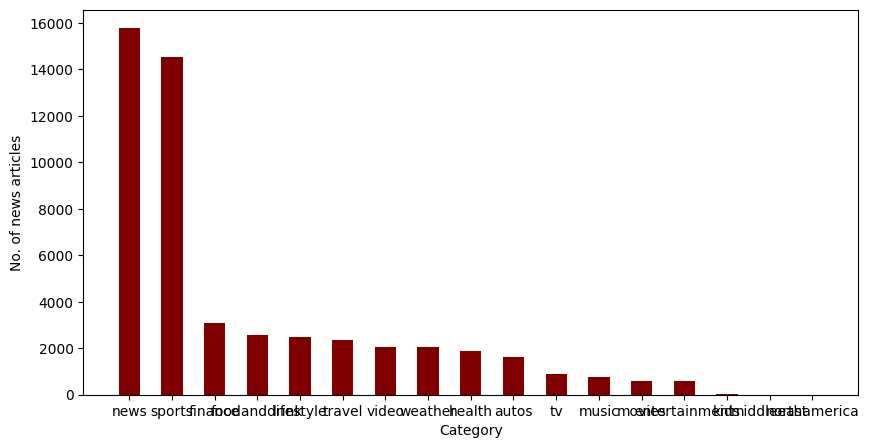

In [20]:
# articles per category/ sub category
# To check (data is balanced) if no. of news articles are balanced over all categories
from collections import Counter
count = Counter(news_raw_data['Category'])
count = pd.Series(count).sort_values(ascending=False)
keys = list(count.keys())

fig = plt.figure(figsize = (10, 5))
plt.bar(keys, count, color ='maroon', width = 0.5,)
 
plt.xlabel("Category")
plt.ylabel("No. of news articles")
plt.show()

In [21]:
print('Number of sub categories: {}'.format(len(news_raw_data['SubCategory'].unique())))

Number of sub categories: 264


In [22]:
# Number of articles clicked per user : average number of clicks per user
# number of clicks per article (from history) : article most clicked
# find number of articles which were not clicked by any user
# time when most articles where clicked by each user or all users
# https://www.kaggle.com/code/bhavnapatel2790/notebookdec438407b?source=post_page-----36a6f1da1b48--------------------------------

### Prepare Data

In [23]:
behaviours_encoded_data = pd.DataFrame(behaviours_raw_data, columns=['Impression ID', 'User ID', 'Time', 'History', 'Impressions'])

In [24]:
# Index all users' IDs in behaviours.csv
unique_users = behaviours_raw_data["User ID"].unique()
user_id_dic = {i : item for i, item in enumerate(unique_users)}
user_keys = list(user_id_dic.keys())
user_values = list(user_id_dic.values())
 
list_user_ids = []
for x in behaviours_raw_data["User ID"]:
    for i in range(len(user_values)):
        if x == user_values[i]:
            list_user_ids.append(user_keys[i])
            break
print("length of list_user_ids: ", len(list_user_ids))

behaviours_encoded_data["User ID"] = list_user_ids

# userid_to_index = { userid: index for index, userid in enumerate(unique_users)}

length of list_user_ids:  156965


In [25]:
# Index News articles in news.csv
id_to_index = {news_id: index for index, news_id in enumerate(news_raw_data['News ID'])}

# Index history
history = behaviours_raw_data['History'].str.split()
behaviours_encoded_data['History'] = history.apply(lambda x: [id_to_index[id] for id in x] if isinstance(x, list) else x)

In [26]:
# ref: https://www.kaggle.com/code/danielpleus/mind-recommender-from-scratch
def process_impression(impression):
    list_of_strgs = impression.split(" ")
    item_tuple = [l.split("-") for l in list_of_strgs]
    noclicks = []
    clicks = []
    
    for item in item_tuple:
        if item[1] =='0':
            noclicks.append(item[0])
        if item[1] =='1':
            clicks.append(item[0])
    return noclicks, clicks

behaviours_encoded_data['Noclicks'], behaviours_encoded_data['Clicks'] = zip(*behaviours_raw_data['Impressions'].map(process_impression))

behaviours_encoded_data['Noclicks'] = behaviours_encoded_data['Noclicks'].map(lambda list_of_strings: [id_to_index[id] for id in list_of_strings])
behaviours_encoded_data['Clicks'] = behaviours_encoded_data['Clicks'].map(lambda list_of_strings: [id_to_index[id] for id in list_of_strings])

In [27]:
# convert given time format to hours
behaviours_encoded_data["Time"] = pd.to_datetime(behaviours_raw_data['Time']).values.astype(np.int64)/(1e6)/1000/3600
behaviours_encoded_data["Time"] = behaviours_encoded_data["Time"].round()

# behaviours_encoded_data.explode("Clicks").reset_index(drop=True)

In [28]:
behaviours_encoded_data.to_csv("behaviours_encoded_data.tsv", header=None)

In [29]:
behaviours_encoded_data.to_pickle('test.df')

In [30]:
# News data
# Index News articles in news.csv
newsids = [index for index, news_id in enumerate(news_raw_data['News ID'])]

### Collaborative filtering
##### Memory-based
- User-User
- https://blog.cambridgespark.com/nowadays-recommender-systems-are-used-to-personalize-your-experience-on-the-web-telling-you-what-120f39b89c3c
- Item-Item
##### Model-based

#### User-based
- User-based: find similarity among users based on users' history
- Based on the assumption that people who agreed in the past will agree in the future, and that they will like similar kinds of items as they liked in the past.
- user_item_history before all impressions


In [34]:
# Let us use the last 10pct of the data as our validation data:
test_time_th = behaviours_encoded_data['Time'].quantile(0.9)
behaviour_train = behaviours_encoded_data[behaviours_encoded_data['Time']< test_time_th]
behaviour_valid =  behaviours_encoded_data[behaviours_encoded_data['Time']>= test_time_th]

In [223]:
behaviour_valid = behaviour_valid.reset_index()

In [224]:
print(behaviour_train.shape)
print(behaviour_valid.shape)

(140712, 7)
(16253, 8)


In [225]:
print('no. of unique History values: ', len(behaviours_raw_data['History'].unique()))
print('no. of unique User ID values: ', len(behaviours_raw_data['User ID'].unique()))

no. of unique History values:  48869
no. of unique User ID values:  50000


- should not drop duplicate users, history might be different for same user depending on the impression Id. As impression id is based on time (given in Time column)

- So, I need to include clicked articles in the impression in the history
- If an user has 3 impression ids then clicks of older impression ids should be included in History 

- Now I have No_clicks and Clicks column derived from impression column

- So I can use Clicks column to update user_item_history matrix.
- get all impressions of a user: check Clicks column value for them and then update in user_item_history matrix

In [226]:
nan_history = behaviour_train['User ID'][behaviour_train['History'].isna()].to_list()
print("List of users ({0}) in df_user_history that has no history: \n{1}".format(len(nan_history), nan_history[0:10]))
print(len(set(nan_history)))

List of users (2836) in df_user_history that has no history: 
[28, 96, 155, 194, 358, 432, 648, 733, 858, 860]
851


In [227]:
nan_history_valid = behaviour_valid['User ID'][behaviour_valid['History'].isna()].to_list()
print("List of users ({0}) in df_user_history that has no history: \n{1}".format(len(nan_history_valid), nan_history_valid[0:10]))
print(len(set(nan_history)))

List of users (402) in df_user_history that has no history: 
[257, 1104, 1795, 2195, 2701, 3252, 3313, 3427, 3313, 4223]
851


In [307]:
# build user-item matrix using history and impressions
unique_users_train = len(noNaN_behaviour_train['User ID'].unique())
unique_items = len(newsids)
print('unique_users_train', unique_users_train)
print('unique_items in news.tsv', unique_items)

user_item_history = np.zeros((unique_users_train, unique_items), dtype = int)
print(user_item_history.shape)

# whereever value is NaN, value in array is zero (we do change in user_item_history).
for i in range(unique_users_train):
    if isinstance(noNaN_behaviour_train['History'].iloc[i], list):
        for item in noNaN_behaviour_train['History'].iloc[i]:
            user_item_history[i][item] = 1
    user = noNaN_behaviour_train['User ID'].iloc[i]
    user_time_list = list(noNaN_behaviour_train['Time'][noNaN_behaviour_train['User ID']==user])
    user_time_sorted = sorted(user_time_list, key = lambda x:float(x))
    if not len(user_time_sorted) == 1:
        for time in user_time_sorted:
            for item in noNaN_behaviour_train['Clicks'][noNaN_behaviour_train['User ID']==user][noNaN_behaviour_train['Time']==time]:
                user_item_history[i][item[0]] = 1

unique_users_train 47117
unique_items in news.tsv 51282
(47117, 51282)


In [308]:
user_item_history.shape

(47117, 51282)

In [309]:
user_item_history_sparse = csr_matrix(user_item_history)
user_item_history_sparse

<47117x51282 sparse matrix of type '<class 'numpy.int64'>'
	with 1788053 stored elements in Compressed Sparse Row format>